In [ ]:
import torch
from torch.utils.data import DataLoader
from dataset import ChestXrayDataset, get_transforms
from ViT_model import ViT


In [32]:
import importlib
import ViT_model
import dataset
importlib.reload(ViT_model)
importlib.reload(dataset)
from ViT_model import ViT

In [33]:
ds = ChestXrayDataset(
    "data_splits/train.txt",
    transform=get_transforms(train=True)
)

#test accessing a sample
x, y = ds[0]
print(x.shape, y)

torch.Size([1, 64, 64]) 0


In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

#define training and validation datasets
train_ds = ChestXrayDataset(
    "data_splits/train.txt",
    transform=get_transforms(train=True)
)

val_ds = ChestXrayDataset(
    "data_splits/val.txt",
    transform=get_transforms(train=False)
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)


Using device: cuda


In [35]:
#define model
model = ViT().to(device)

#define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

In [36]:
#training loop
train_loss_history = []
val_loss_history = []


for epoch in range(30): #train for 30 epochs
    model.train()
    total_loss = 0

    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    with torch.no_grad():
        model.eval()
        val_loss = 0

        for batch_idx, (x, y) in enumerate(val_loader):
            x, y = x.to(device), y.to(device)

            logits = model(x)
            loss = criterion(logits, y)

            val_loss += loss.item()
            
    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    val_loss_history.append(avg_val_loss)
    train_loss_history.append(avg_train_loss)
    
    print(f"Epoch {epoch+1}/{30} Complete | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print("-" * 60)


Epoch 1/30 Complete | Train Loss: 0.9213 | Val Loss: 0.9240
------------------------------------------------------------
Epoch 2/30 Complete | Train Loss: 0.6343 | Val Loss: 0.5475
------------------------------------------------------------


KeyboardInterrupt: 

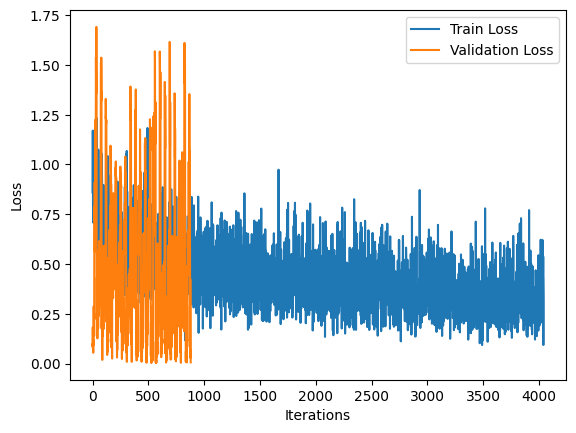

In [8]:
#plotting loss curves
import matplotlib.pyplot as plt

plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
from sklearn.metrics import classification_report

#evaluate per class performance

test_ds = ChestXrayDataset(
    "data_splits/test.txt",
    transform=get_transforms(train=False)
)

test_loader = DataLoader(test_ds, batch_size=32)

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)

        logits = model(x)
        predictions = torch.argmax(logits, dim=1)

        y_true.extend(y.cpu().numpy())
        y_pred.extend(predictions.cpu().tolist())

print(classification_report(y_true, y_pred, target_names=["Normal", "Bacterial", "Viral", "COVID-19"]))

              precision    recall  f1-score   support

      Normal       0.89      0.98      0.93       492
   Bacterial       0.78      0.82      0.80       451
       Viral       0.66      0.46      0.54       249
    COVID-19       0.95      0.97      0.96       193

    accuracy                           0.83      1385
   macro avg       0.82      0.81      0.81      1385
weighted avg       0.82      0.83      0.82      1385



In [ ]:
#save model
torch.save(model.state_dict(), "vit_baseline.pth")